## LSTM

RNNs are used with sequential data. Through hidden states, the networks remember previous observations and use them to generate our predictions. While they are most commonly in the form of text, it can be any sequential data. We will be focusing on time-series data in these examples. If you are interested in text applications, please see the bonus_nlp notebook. 

LSTM models are the most commonly used RNN architecture. It uses a variety of 'gates' to determine which of the previous sequential memory to remember and incorporate into the model. Please see the 'bonus_basic_rnn_background' notebook for a more detailed explaination of RNNs and LSTMs. 

## Example Problem - Predicting the Number of Passengers

We will be using a dataset from the seaborn package - 'flights'. You can type sns.get_dataset_names() to see all of the datasets in the package.

It contains three columns - year, month, and passengers for 12 years of travel. We want to predict the number of passengers in the last year based on the values of the first 11. 

In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


In [3]:
# Change the plot window
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

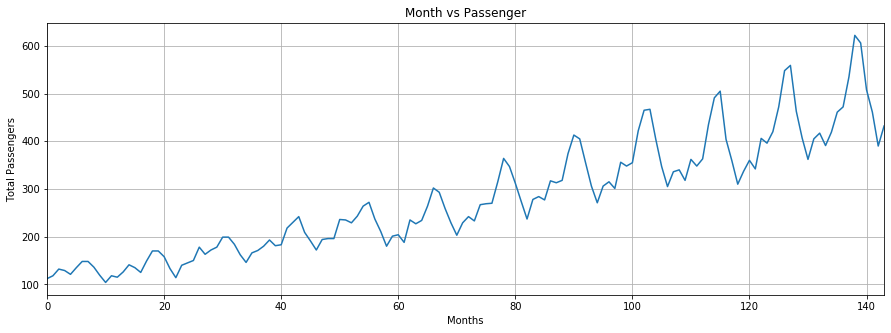

In [4]:
# Plot the number of passengers over time
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
_ = plt.plot(flight_data['passengers'])

In [5]:
# Get the X data as a float

all_data = flight_data['passengers'].values.astype(float)
print(all_data)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


We now need to split out data into training and test. We can't use our normal method of randomly splitting it since we want to preserve the sequence. Since we want to predict the last year, we will be splitting into the training of the first 132 months and the test of the last 12 months. 

We will need to scale our data next. We normally scale our test data as well. This enables us to quickly and easily calculate our accuracy. However, we have lost our interpretability. Here we will present another option - converting our predictions back to our orginal scale before looking at our accuracy. You can see that this would be more useful for planning the number of airplanes to have ready. Other applications, such as predicting diabetes, don't need this inverse transformation.

Lastly, we will convert our scaled training data into a tensor.

In [6]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

We need to turn our data into sequences to feed into our model. We have stated that our goal is to predict a current time period using several past time period. In our plot above, we can note that along with a gradual overall increase - there is a seasonality to the demand (peaks and valley during different months that are the same every year). This makes sense as more people travel around Christmas and in the summer. So using 12 as a sequence length makes sense - we will use a year of data to predict the amount of travel in the next month.

To do this, we will create a sequence of data containing the data from months 0-11 to predict the data in month 12. Next we will use 1-12 to predict 13. And so on.

The code below generates sequences that are tuples. The first element is our input data (0-11) while the second element is the target (12).

In [8]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [9]:
train_window = 12
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [10]:
train_inout_seq[:1]

[(tensor([-1.4168, -1.3603, -1.2285, -1.2567, -1.3321, -1.2003, -1.0779, -1.0779,
          -1.1908, -1.3509, -1.4921, -1.3603]),
  tensor([-1.3885]))]

Time to make our model! We will be using the class structure so that we can inherit functionality from nn.Module. You always want to do this - even if coding a class is slightly more complicated than a normal function.

We are going to make a single layer LSTM with a single linear layer to convert our RNN output into a final prediction. There are three key input values to our class: input size, hidden_layer_size, and output_size.

Input size is the number of features in the input. While we have 12 elements in our input sequence, each month only has one value so this parameter will be one.

Hidden_layer_size is the number of neurons in each hidden layer - which is our LSTM layer here. There is no real rule of thumb or exact answer. One approach is to take $N_{h} = \frac{N_{s}}{\alpha * (N_{i} + N_{o}))}$ where N_h is the number of hidden neurons, N_s is the number of samples in the training set, N_i iis the number of input neurons, N_o is the number of output neurons, and alpha is a number between 2-10. You generate these 8 values and try them out to see which gives you the best results. We will just use alpha of 2 here and do it once.

Output_size is the number of items in the output. We are predicting one value here so output size is 1.

hidden_cell contains information on the previous hidden and cell state. That is why there are two elements in the self.hidden_cell.

The final prediction is stored as the last item of the predictions list - which is why we return predictions[-1]

In [64]:
N_h = (len(train_inout_seq))/(2 * (1 + 1))
N_h = int(N_h)
N_h

30

In [66]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=N_h, output_size=1):
        super().__init__() # Inherit from nn.Module
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq, all_preds = False):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        if all_preds:
            return predictions
        return predictions[-1]

Time to create our model and set our loss function and optimizer

In [67]:
model = LSTM()
loss_function = nn.MSELoss() # since a regression problem
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 30)
  (linear): Linear(in_features=30, out_features=1, bias=True)
)


Time to train the network. We will do our normal strategy of iterating over the epochs. We are treating each input sequence as a batch and iterate through them as well.

Everything else is as you have seen it before. It takes a little while to run and only prints the loss every 25 epochs - so be patient. Note: you might get different loss values than I do since the default weight of your model are initalized randomly.

In [84]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00000024
epoch:  26 loss: 0.00000018
epoch:  51 loss: 0.00000215
epoch:  76 loss: 0.00002730
epoch: 101 loss: 0.00000154
epoch: 126 loss: 0.00000746
epoch: 149 loss: 0.0000744734


Time to make some predictions! This part can be a little tricky. We are going to use the last twelve values in the training set to predict the first test value. We will use the last 11 training values and the first test prediction to predict the second test value. The last test value will be predicted with the last training value and the first eleven predicted values.

This is an unusual way for us to use training data. Normally, we would just use all of the test data to make a single prediction for the 13th month. However, we don't have a 13th test value. This model would have to be validated with live data and likely the training data will have to be constantly updated. 

We achieve this by creating a list of the last 12 training values and appending the prediction to it. Then we use the last 12 values of this created list as our input each time.

In [85]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()

In [86]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [87]:
preds = test_inputs[fut_pred:]
preds

[1.680790901184082,
 2.2487504482269287,
 2.6735222339630127,
 2.6303913593292236,
 2.3643906116485596,
 2.206479549407959,
 2.405409097671509,
 2.6673529148101807,
 2.6092309951782227,
 2.466414451599121,
 2.286298990249634,
 2.094928026199341]

In [88]:
actual_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
print(actual_predictions)

[[441.02795919]
 [501.3572729 ]
 [546.47701857]
 [541.89560766]
 [513.64070353]
 [496.8672096 ]
 [517.9977341 ]
 [545.82170643]
 [539.64792954]
 [524.47779268]
 [505.34572204]
 [485.01807902]]


In [89]:
# Error
from sklearn.metrics import mean_squared_error
import math

print(math.sqrt(mean_squared_error(test_data, actual_predictions)))

78.69937009215352


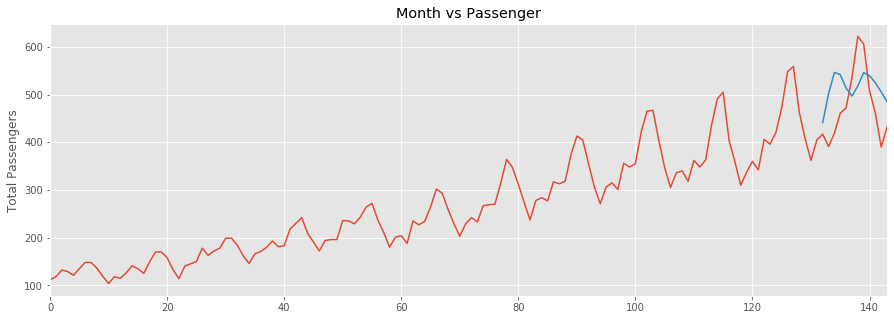

In [90]:
x = np.arange(132, 144, 1)
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

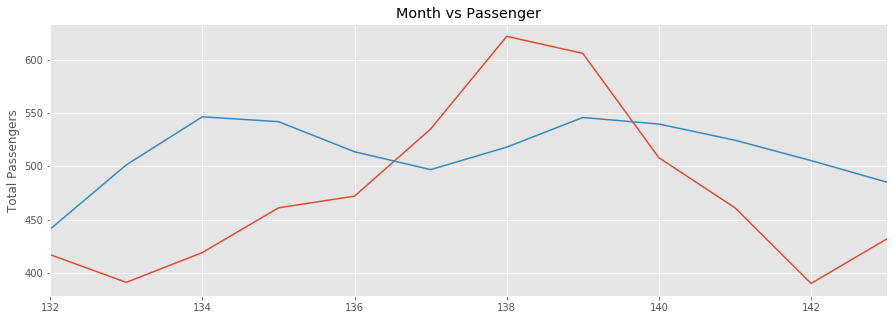

In [91]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()

So we got a RMSE of 84 and we under predicted our demand in the peak month. This would lead to inflated overhead costs out of the peak and lost revenue during the peak.

I tried changing the number of hidden neurons and epochs but couldn't get any results that were consistently better. This might be an example of needing better data.

## Your turn

We are going to use market data on the Starbucks stock to predict its trading volume. This [matters](https://gilmartinir.com/why-does-trading-volume-matter/) because it allows investors to make decisions on whether to buy or sell their stock. If you predict that volume will increase, you would want to hold onto your stock in the hopes of a better price (if there is a positive price trend) while if demand if predicted to drop yo might want to sell it to ensure you can capture a high price. All financial models are fairly awful and will perform horribly on future data. The [efficient market hypothesis](https://www.investopedia.com/terms/e/efficientmarkethypothesis.asp) essentially states that it is impossible to figure out the market and this is born out in empircial data with no traders constantly outperforming the market. Predicting price change is even harder. With only 5 daily prices as predictors, we are facing an uphill battle (you would want macro economic indicators, weather data, political variables, etc.). It is still a fun exercise.

So, you need to load in the starbucks data and make the first 5 columns your X and the last column into your Y. Please split the data - remembering that order matters. I used 200 training observations and 53 test since it is roughly an 80/20 split. 

You can use the network that we defined before or write your own - I will be reusing the one above. An important difference is that we now want all of the predictions to be returned. 

Additionally, since this is a much more complex dataset that is extremely volatile, I will be adding an extra LSTM layer to my model. Check out the nn.LSTM [documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) if you want to try as well. An extra hint is that you will need to change your forward call as well to be able to contain the two hidden states.

Lastly, if you want to rescale your y values in the end, make sure to train a separate scaler for your y train.

In [22]:
import numpy as np
import pandas as pd
df = pd.read_csv('SBUX.csv', index_col = 'Date', parse_dates=True)

In [23]:
df.shape

(253, 6)

In [24]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,84.480545,4921900
2019-12-12,88.000000,88.889999,87.540001,88.209999,86.061089,10282100
2019-12-13,88.019997,88.790001,87.580002,88.669998,86.509880,6714100
2019-12-16,89.139999,89.300003,88.430000,88.779999,86.617203,6705600
2019-12-17,88.870003,88.970001,87.470001,88.129997,85.983040,7296900


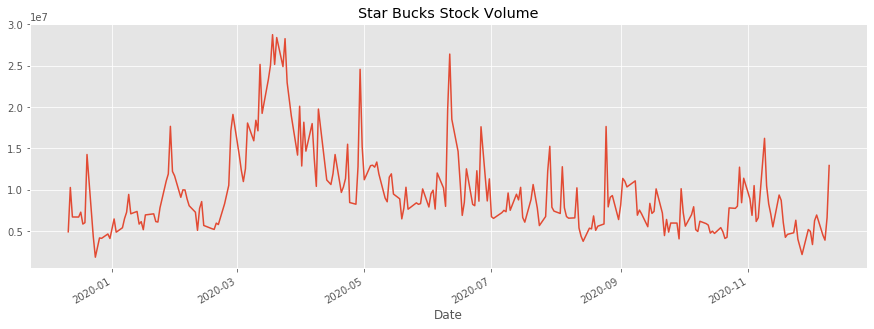

In [25]:
plt.style.use('ggplot')
_ = df['Volume'].plot(label='CLOSE', title='Star Bucks Stock Volume')

Looks like we did alright! Can you make it any better? You could try adding more linear layers, more LSTM layers, changing the number of hidden nodes, adjusting the learning rate, or more.

That is the end of this tutorial. Thanks for attempting it!

## Additional Resources

[LSTM stock price prediction](https://www.datacamp.com/community/tutorials/lstm-python-stock-market)

[LSTM Sentiment analysis](https://towardsdatascience.com/machine-learning-recurrent-neural-networks-and-long-short-term-memory-lstm-python-keras-example-86001ceaaebc)

